In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
YEAR = 2017
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / f"reanalyze_csvs_{YEAR}.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_81355/847787845.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(frames)


In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,8209,1,binospec,8209
f5,4698,1,f5,4698
mmirs,20200,1,mmirs,20200
newf9,974,1,newf9,974
oldf9,3093,1,oldf9,3093


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[np.isfinite(data['vlt_seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,vlt_seeing,raw_vlt_seeing,ellipticity
77,2017-01-05T01:11:47,oldf9,manual_wfs_0000.fits,5.0,1.4200,253.320000,44.850000,8.03,3.4,4.000,...,218.003712,236.000115,0.749699,0.925252,7.386037,2727.132292,1890.926300,0.799379,0.986565,0.064533
78,2017-01-05T01:12:19,oldf9,manual_wfs_0001.fits,5.0,1.4200,253.420000,44.740000,7.92,3.4,3.900,...,219.995998,231.013950,0.795305,0.981537,7.661474,602.346318,2164.341220,0.873007,1.077434,0.090599
0,2017-01-05T01:12:45,oldf9,auto_wfs_0000.fits,5.0,1.4200,253.510000,44.650000,7.90,3.4,3.800,...,218.002908,234.999255,0.763320,0.942062,7.468220,394.485931,1885.182363,0.791314,0.976612,0.040264
1,2017-01-05T01:13:08,oldf9,auto_wfs_0001.fits,5.0,1.4200,253.580000,44.580000,7.82,3.4,3.800,...,244.007442,257.995661,0.833823,1.029074,7.894595,304.136852,1966.257077,0.866306,1.069164,0.058457
2,2017-01-05T01:13:16,oldf9,auto_wfs_0002.fits,5.0,1.4300,253.600000,44.550000,7.82,3.4,3.800,...,241.023077,260.023506,0.761243,0.943464,7.475074,437.371856,2067.236066,0.834924,1.034782,0.095472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,2017-12-31T08:09:06,newf9,f9wfs_20171231-010906.fits,10.0,1.4878,120.711226,42.233021,7.12,7.8,7.169,...,403.998218,434.998906,0.617448,0.783659,7.893445,1555.171417,1307.811995,0.623925,0.791879,0.047074
16,2017-12-31T08:10:03,newf9,f9wfs_20171231-011004.fits,10.0,1.4827,120.933088,42.410122,7.12,7.8,7.158,...,397.999079,436.998509,0.606810,0.768572,7.796420,799.228787,1487.598560,0.625245,0.791922,0.071646
17,2017-12-31T08:11:01,newf9,f9wfs_20171231-011102.fits,10.0,1.4778,121.153823,42.584959,7.10,7.7,7.088,...,402.001398,431.998317,0.629330,0.795513,7.969723,535.218614,1466.266969,0.652388,0.824661,0.087973
90,2023-04-18T00:02:06,f5,manual_wfs_0014.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,253.991135,247.008840,0.590356,0.590356,4.637797,685.286497,1436.383861,0.598662,0.598662,0.102495


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))
fixed = fixed[(fixed.index >= f"{YEAR}-01-01") & (fixed.index < f"{YEAR+1}-01-01")]

<Figure size 800x500 with 0 Axes>

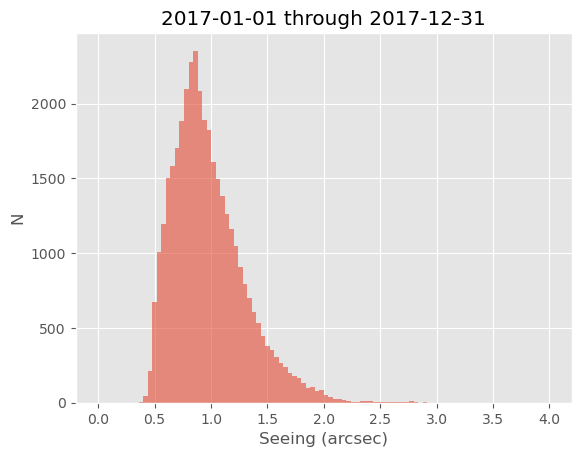

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [8]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.40003343077388326 0.19140429726465508 0.7267683810146924


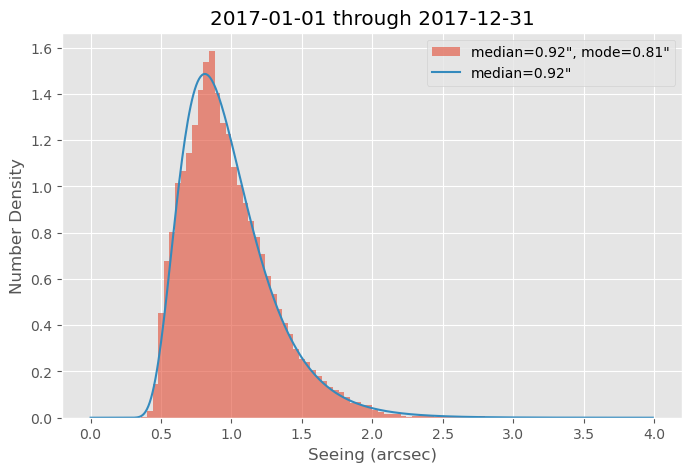

In [9]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_allyear.png")
plt.show()

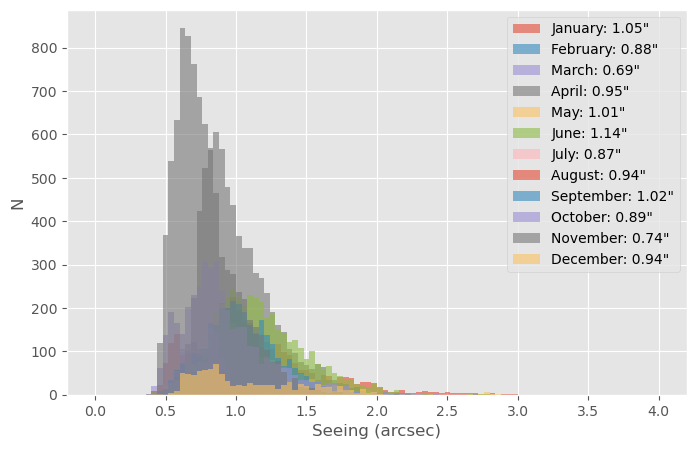

In [10]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months["January"] = fixed.loc[f"{YEAR}-01"]
months["February"] = fixed.loc[f"{YEAR}-02"]
months["March"] = fixed.loc[f"{YEAR}-03"]
months["April"] = fixed.loc[f"{YEAR}-04"]
months["May"] = fixed.loc[f"{YEAR}-05"]
months["June"] = fixed.loc[f"{YEAR}-06"]
months["July"] = fixed.loc[f"{YEAR}-07"]
months["August"] = fixed.loc[f"{YEAR}-08"]
months["September"] = fixed.loc[f"{YEAR}-09"]
months["October"] = fixed.loc[f"{YEAR}-10"]
months["November"] = fixed.loc[f"{YEAR}-11"]
months["December"] = fixed.loc[f"{YEAR}-12"]
for m in months:
    plt.hist(months[m]["vlt_seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]["vlt_seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_monthly.png")
plt.show()

In [11]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

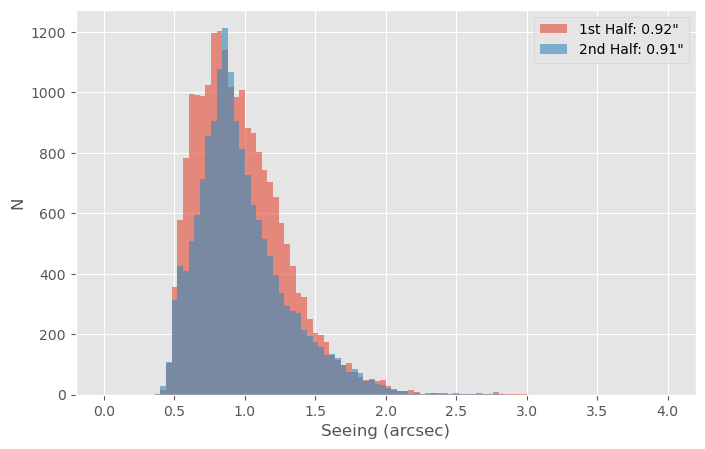

In [12]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_1st2nd.png")
plt.show()

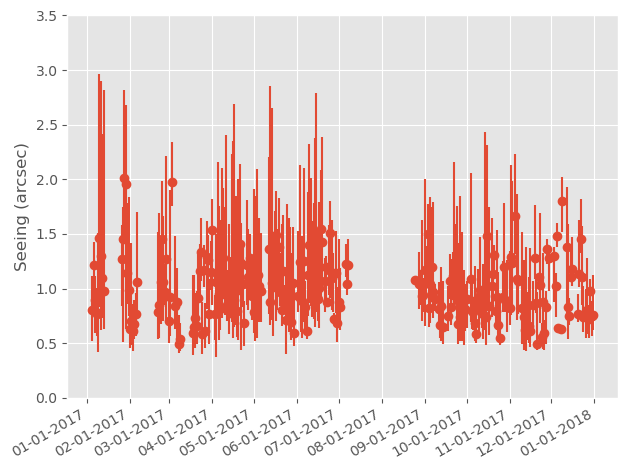

In [13]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_nightly.png")
plt.show()

In [14]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

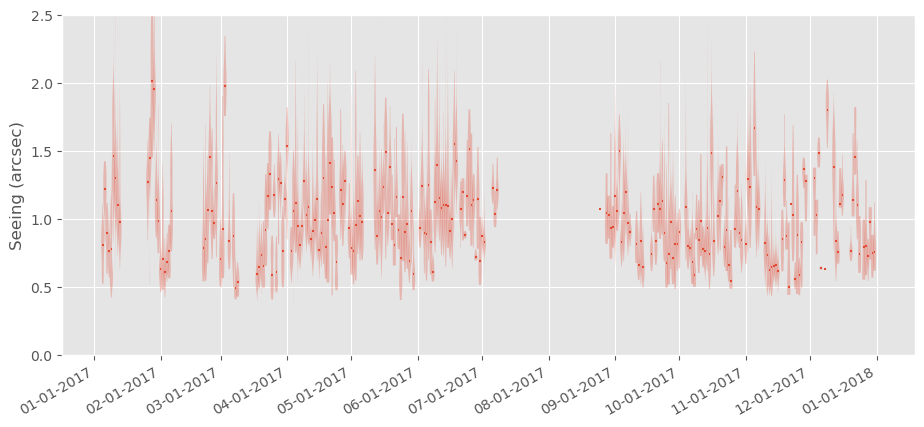

In [15]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin.png")
    plt.show()

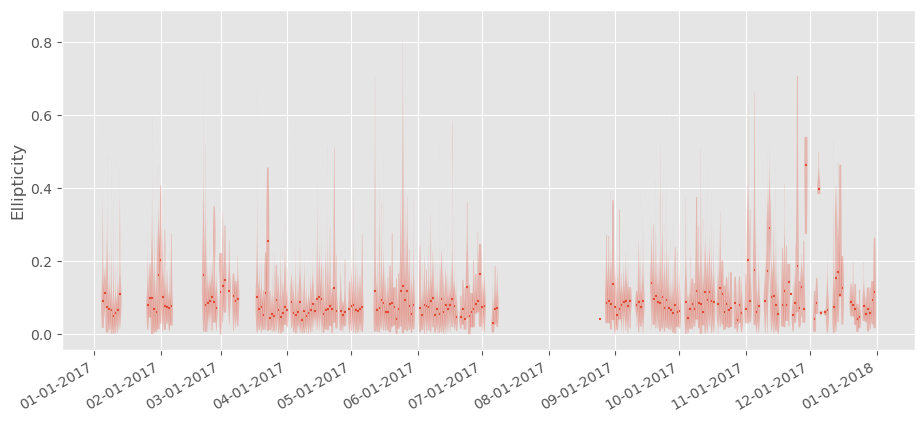

In [16]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig(f"{YEAR}_ellip_violin.png")
    plt.show()

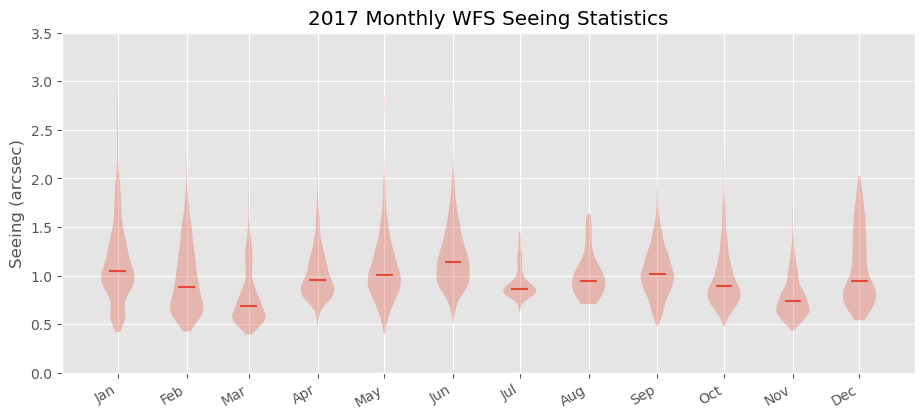

In [17]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin_monthly.png")
    plt.title(f"{YEAR} Monthly WFS Seeing Statistics")
    plt.show()

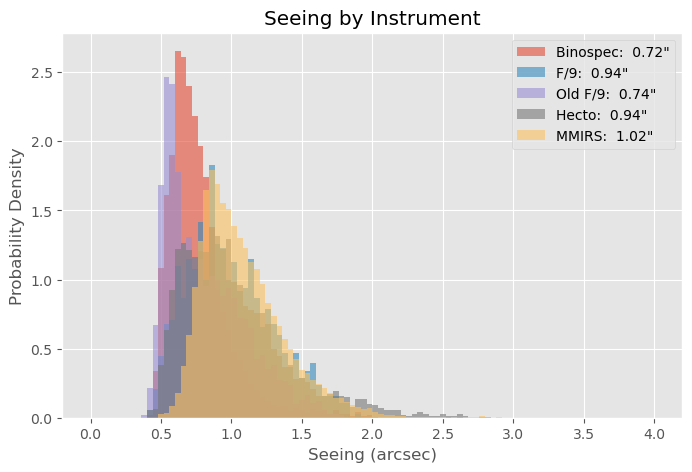

In [19]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    med9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'])
    medo9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'oldf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'oldf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Old F/9: {medo9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig(f"per_instrument_{YEAR}.png")
plt.show()

In [20]:
f9 = fixed[fixed['wfs'] == 'newf9']
oldf9 = fixed[fixed['wfs'] == 'oldf9']
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [21]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
oldf9_dates = sorted(list(set(oldf9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2017-11-10',
  '2017-11-11',
  '2017-11-12',
  '2017-11-13',
  '2017-11-14',
  '2017-11-15',
  '2017-11-16',
  '2017-12-06',
  '2017-12-08',
  '2017-12-09',
  '2017-12-12',
  '2017-12-13',
  '2017-12-14',
  '2017-12-15'],
 ['2017-01-28',
  '2017-01-29',
  '2017-01-30',
  '2017-01-31',
  '2017-02-01',
  '2017-02-02',
  '2017-02-03',
  '2017-02-04',
  '2017-02-05',
  '2017-02-06',
  '2017-02-21',
  '2017-02-22',
  '2017-02-23',
  '2017-02-24',
  '2017-02-25',
  '2017-02-26',
  '2017-02-27',
  '2017-03-01',
  '2017-03-02',
  '2017-03-03',
  '2017-04-18',
  '2017-04-19',
  '2017-04-20',
  '2017-04-21',
  '2017-04-22',
  '2017-04-23',
  '2017-04-24',
  '2017-04-26',
  '2017-04-27',
  '2017-04-28',
  '2017-04-30',
  '2017-05-01',
  '2017-05-02',
  '2017-05-03',
  '2017-05-04',
  '2017-05-05',
  '2017-05-06',
  '2017-05-24',
  '2017-05-25',
  '2017-05-26',
  '2017-05-27',
  '2017-05-28',
  '2017-05-29',
  '2017-05-30',
  '2017-06-02',
  '2017-06-03',
  '2017-06-04',
  '2017-06-05',
  '2017

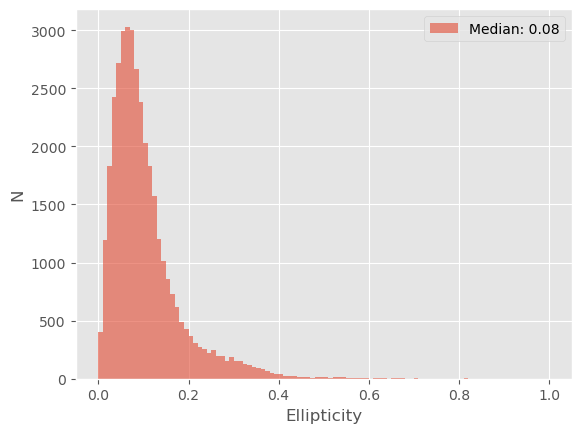

In [22]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig(f"ellipticity_{YEAR}.png")
plt.show()


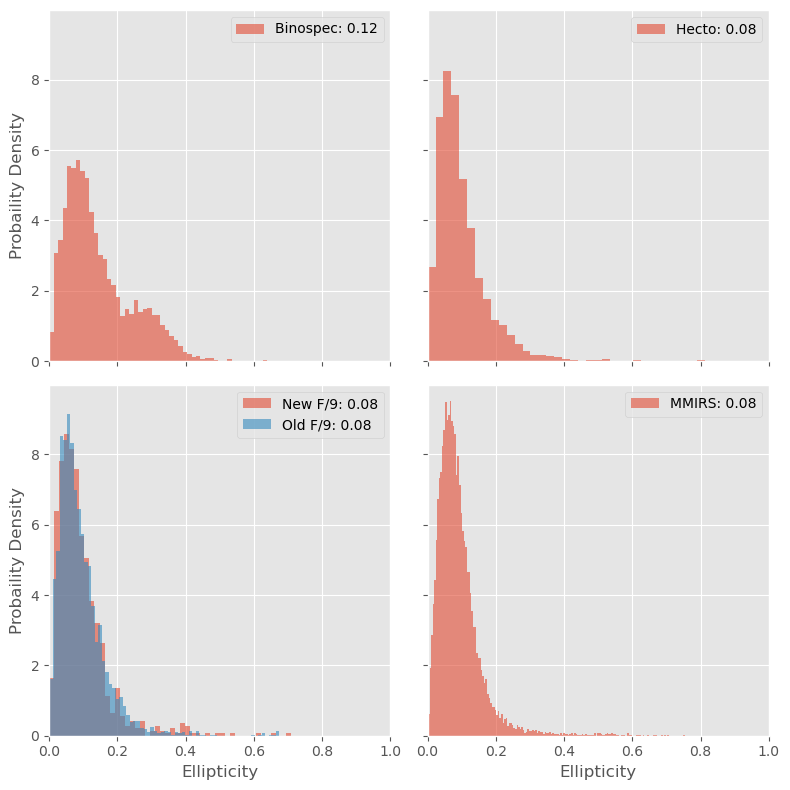

In [24]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(bino['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['ellipticity']):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 1)

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[1].set_xlim(0, 1)

    hist(f9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True, label=f"New F/9: {np.median(f9['ellipticity']):.2f}")
    hist(oldf9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True, label=f"Old F/9: {np.median(oldf9['ellipticity']):.2f}")
    ax[2].legend()
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[3].set_xlim(0, 1)
    ax[3].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_ellip_vs_inst.png")
    plt.show()